<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/3_0_LSTM_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12C%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20LSTMs.ipynb



Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
# DATA_DIR = "dataset/feature_files"
MODEL_NAME = "LSTM"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"




DEBUG = False



MODEL_NAME = "LSTM"
ARCHITECTURE = "1"
DESCRIPTION = "1 Layer 64 LSTM Units and 20% 1D Spatial Dropout"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 8

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"
  # DATA_FILE = f"{DRIVE_DIR}/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"


# directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
# DESCRIPTION = f"{MODEL_NAME}-{ARCHITECTURE}-nobatch-{INBASENAME}-sampling_none-{FEATURE_COLUMN}"



# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3

LSTM_DIM = 64 # total LSTM units


# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=45009
Number of Documents=149350
Train review vectors shape: (149350, 100)  Test review vectors shape: (49784, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          13503000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 13,596,765
Trainable params: 13,596,765
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop, reduce_lr])

Number of training examples: 149350
Train on 119480 samples, validate on 29870 samples
Epoch 1/50
119480/119480 [==============================] - 361s 3ms/sample - loss: 0.9245 - categorical_accuracy: 0.6459 - val_loss: 0.8460 - val_categorical_accuracy: 0.6763
Epoch 2/50
119480/119480 [==============================] - 357s 3ms/sample - loss: 0.7936 - categorical_accuracy: 0.6915 - val_loss: 0.8264 - val_categorical_accuracy: 0.6825
Epoch 3/50
119480/119480 [==============================] - 352s 3ms/sample - loss: 0.7263 - categorical_accuracy: 0.7188 - val_loss: 0.8272 - val_categorical_accuracy: 0.6823
Epoch 4/50
119480/119480 [==============================] - 354s 3ms/sample - loss: 0.6669 - categorical_accuracy: 0.7449 - val_loss: 0.8469 - val_categorical_accuracy: 0.6776
Epoch 00004: early stopping


Number of test: 49784
Running model.evaluate...
49784/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

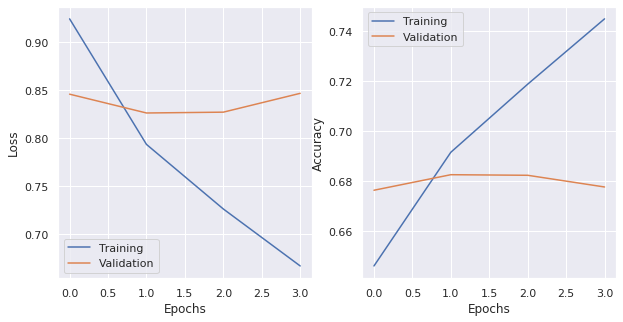


Confusion Matrix
[[ 5373   481   503   166   458]
 [ 1476   437   719   257   336]
 [  784   360  1426   909  1061]
 [  265   110   829  2538  4556]
 [  318    88   454  1834 24046]]

Classification Report
              precision    recall  f1-score   support

           1       0.65      0.77      0.71      6981
           2       0.30      0.14      0.19      3225
           3       0.36      0.31      0.34      4540
           4       0.44      0.31      0.36      8298
           5       0.79      0.90      0.84     26740

    accuracy                           0.68     49784
   macro avg       0.51      0.48      0.49     49784
weighted avg       0.64      0.68      0.65     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

0.30489691706613076

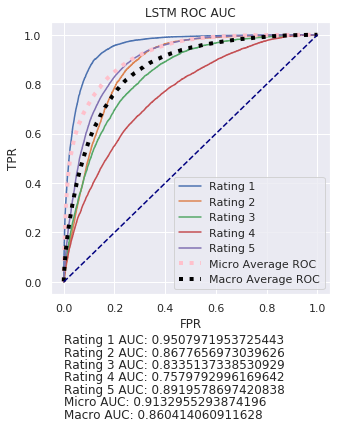

In [11]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [12]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.30489691706613076


**Save off various files**

In [9]:

mw.save(DRIVE_DIR, append_report=True)


description: LSTM-1-random_embedding-sampling_none-199134-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTM-1-random_embedding-sampling_none-199134-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTM-1-random_embedding-sampling_none-199134-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTM-1-random_embedding-sampling_none-199134-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'LSTM', 'architecture': '1', 'description': '1 Layer 64 LSTM Units and 20% 1D Spatial Dropout', 'classification_report': '{"1": {"precision": 0.6539678675754625, "recall": 0.7696605070906747, "f1-score": 0.7071132460354017, "support": 6981}, "2": {"precision": 0.296070460704607, "recall": 0.13550387596899

In [10]:
print(datetime.now())

2019-11-07 04:51:58.073345
